# Guided mode expansion of a PhC slab with vertical (kz) symmetry plane

In this example we apply `legume` to calculate the bands of a PhC slab with vertical (kz) mirror planes, i.e., vertical planes that are defined by the wavevector ${\bf k}$ and the $z$ axis. Such plane exist in symmetric lattices (like the square and hexagonal lattice) only along some symmetry-directions in k-space. This example is related to Sec. 3.1 of the CPC paper.

This feature is new to Legume 1.0 (2024 version, CPC paper).

In [ ]:
import sys
sys.path.append("/content/legume")
import legume
print(f"Version of the imported legume : {legume.__version__}")

import numpy as np
import matplotlib.pyplot as plt

Version of the imported legume : 1.0.1


We adopt the parameters of Fig. 6(b) of the CPC paper

Here we exploit a new feature in legume 1.0, namely symmetry (or parity) separation with respect to reflection $\sigma_{kz}$ in a vertical mirror plane that contains the 2D wavevector ${\bf k}$. This mirror symmetry holds only along special symmetry directions of the lattice, e.g, the $\Gamma$-X and $\Gamma$-M directions of the square lattice, and the $\Gamma$-K and $\Gamma$-M directions of the triangular lattice.

Symmetry separation is controlled by the keyword argument `symmetry` which can have four values:
* `symmetry = None`: no symmetry separation (in this case it is not a string)
* `symmetry = 'even'`: only modes with $\sigma_{kz}=+1$ are calculated
* `symmetry = 'odd'`:  only modes with $\sigma_{kz}=-1$ are calculated
* `symmetry = 'both'`: both modes with $\sigma_{kz}=+1$ and with $\sigma_{kz}=-1$ are calculated separately

In [ ]:
D = 0.5          # slab thickness in units of a
r = 0.2          # hole radius in units of a
eps_c = 1        # dielectric constant of circular hole
eps_b = 3.54**2  # background dielectric constant of slab
eps_lower, eps_upper = 1.45**2, 1  # dielectric constants of lower and upper claddings

lattice = legume.Lattice('square')
phc = legume.PhotCryst(lattice, eps_l=eps_lower, eps_u=eps_upper)
phc.add_layer(d=D, eps_b=eps_b)
phc.layers[-1].add_shape(legume.Circle(eps=eps_c, r=r, x_cent=0., y_cent=0))
gme = legume.GuidedModeExp(phc, gmax=4.5, truncate_g='abs')

npw =  69


In [ ]:
path = lattice.bz_path(['X', 'G', 'M'], [50, 80])
gmode_inds, numeig, verbose, compute_im = [0, 1, 2, 3], 40, True, False


gme = legume.GuidedModeExp(phc, gmax=4, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry='even',
        numeig=numeig, verbose=True, compute_im=compute_im)
freqs_even = gme.freqs

gme = legume.GuidedModeExp(phc, gmax=5, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry='odd',
        numeig=numeig, verbose=True, compute_im=compute_im)
freqs_odd = gme.freqs

Plane waves used in the expansion = 49.
21.166s total time for real part of frequencies, of which
  13.198s (62%) for guided modes computation using the gmode_compute='exact' method
  0.021s (0%) for inverse matrix of Fourier-space permittivity
  0.916s (4%) for matrix diagionalization using the 'eigh' solver
  4.242s (20%) for creating GME matrix
  2.221s (10%) for creating change of basis matrix and multiply it using dense matrices
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
Plane waves used in the expansion = 81.
35.796s total time for real part of frequencies, of which
  19.913s (56%) for guided modes computation using the gmode_compute='exact' method
  0.001s (0%) for inverse matrix of Fourier-space permittivity
  2.446s (7%) for matrix diagionalization using the 'eigh' solver
  7.577s (21%) for creating GME matrix
  5.327s (15%) for creating change of basis matrix and multiply it using dense m

In [ ]:
# define light lines for the plot
eps_clad = [gme.phc.claddings[0].eps_avg, gme.phc.claddings[-1].eps_avg]
light_lower_clad = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(eps_clad[0])
light_upper_clad = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(eps_clad[1])

(0.0, 0.36)

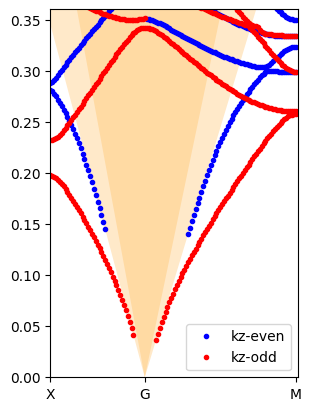

In [ ]:
# plot the photonic bands with even/odd separation
markersize = 3
nkappa = np.shape(path['kpoints'])[1]
kappa = range(nkappa)
ymin, ymax = 0, 0.36
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(3, 4))

nfreqs_even = freqs_even.shape[1]
for j in range(nfreqs_even):
  if (j == 0):
    ax.plot(kappa, freqs_even[:,j], 'bo', markersize=markersize, label='kz-even')
  else:
    ax.plot(kappa, freqs_even[:,j], 'bo', markersize=markersize)

nfreqs_odd = freqs_odd.shape[1]
for j in range(nfreqs_odd):
  if (j == 0):
    ax.plot(kappa, freqs_odd[:,j], 'ro', markersize=markersize, label='kz-odd')
  else:
    ax.plot(kappa, freqs_odd[:,j], 'ro', markersize=markersize)

ax.set_xlim([0, nkappa])

ax.fill_between(kappa, light_lower_clad,  max(100, light_lower_clad.max()),
                facecolor='#FFE9C9',        zorder=0)
ax.fill_between(kappa, light_upper_clad,  max(100, light_upper_clad.max()),
                facecolor='#FFDAA3',        zorder=0)
ax.legend()


ax.set_xticks(path['indexes'], path['labels'])
ax.set_ylim([ymin, ymax])

We can compare with the bands without symmetry separation (like in the original versione of legume, using the option `kz_symmetry=None`.
Also, we can calculate bands of both parities in one shot using the option  `kz_symmetry='both'`. This is faster than calculating even and odd modes separately, but we have to extract the results in the proper way.

In [ ]:
path = lattice.bz_path(['X', 'G', 'M'], [35, 50])
gmode_inds, numeig, verbose, compute_im = [0, 1, 2, 3], 40, True, False

gme = legume.GuidedModeExp(phc, gmax=4.5, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry=None,
        numeig=numeig, verbose=True, compute_im=compute_im)
freqs_none = gme.freqs

gme = legume.GuidedModeExp(phc, gmax=5.5, truncate_g='abs')
gme.run(kpoints=path['kpoints'], angles=path['angles'], gmode_inds=gmode_inds, kz_symmetry='both',
        numeig=numeig, verbose=True, compute_im=compute_im)
freqs_both = gme.freqs
kz_symms = gme.kz_symms  # this is the array that contains the parities of the modes: +1 for even, -1 for odd

18.999s total time for real part of frequencies, of which
  10.764s (57%) for guided modes computation using the gmode_compute='exact' method
  0.002s (0%) for inverse matrix of Fourier-space permittivity
  4.474s (24%) for matrix diagionalization using the 'eigh' solver
  3.384s (18%) for creating GME matrix
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
28.809s total time for real part of frequencies, of which
  13.672s (47%) for guided modes computation using the gmode_compute='exact' method
  0.002s (0%) for inverse matrix of Fourier-space permittivity
  4.394s (15%) for matrix diagionalization using the 'eigh' solver
  5.917s (21%) for creating GME matrix
  4.507s (16%) for creating change of basis matrix and multiply it using dense matrices
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


In [ ]:
# here we separate the array freqs into even and odd frequencies

freqs_both_even = copy.deepcopy(freqs_both)
freqs_both_even[kz_symms==-1] = None
freqs_both_odd = copy.deepcopy(freqs_both)
freqs_both_odd[kz_symms==1] = None

In [ ]:
eps_clad = [gme.phc.claddings[0].eps_avg, gme.phc.claddings[-1].eps_avg]
light_lower_clad = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(eps_clad[0])
light_upper_clad = np.sqrt(
         np.square(gme.kpoints[0, :]) +
         np.square(gme.kpoints[1, :])) / 2 / np.pi / np.sqrt(eps_clad[1])

Text(0.5, 1.0, 'blue=even,  red=odd')

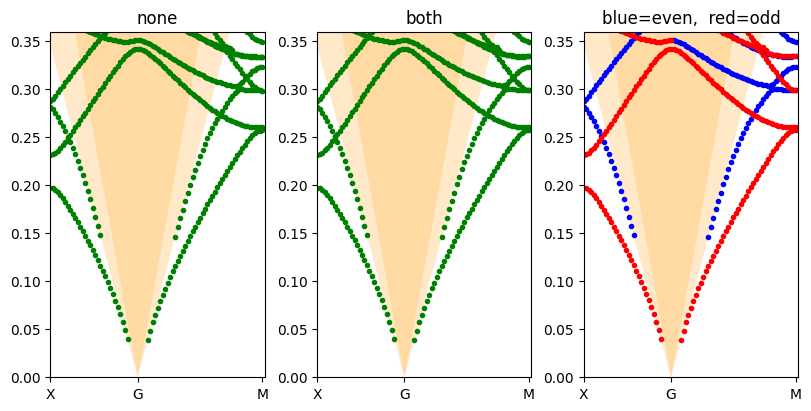

In [ ]:
markersize = 3
nkappa = np.shape(path['kpoints'])[1]
#nkappa = freqs.shape[0]
kappa = range(nkappa)
ymin, ymax = 0, 0.36

fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(8, 4))
ax[0].plot(kappa, freqs_none, 'go', markersize=markersize)
ax[0].set_xlim([0, nkappa])
ax[0].fill_between(kappa, light_lower_clad,  max(100, light_lower_clad.max()),
                facecolor='#FFE9C9',        zorder=0)
ax[0].fill_between(kappa, light_upper_clad,  max(100, light_upper_clad.max()),
                facecolor='#FFDAA3',        zorder=0)
ax[0].set_xticks(path['indexes'], path['labels'])
ax[0].set_ylim([ymin, ymax])
ax[0].set_title('none')

ax[1].plot(kappa, freqs_both, 'go', markersize=markersize)
ax[1].set_xlim([0, nkappa])
ax[1].fill_between(kappa, light_lower_clad,  max(100, light_lower_clad.max()),
                facecolor='#FFE9C9',        zorder=0)
ax[1].fill_between(kappa, light_upper_clad,  max(100, light_upper_clad.max()),
                facecolor='#FFDAA3',        zorder=0)
ax[1].set_xticks(path['indexes'], path['labels'])
ax[1].set_ylim([ymin, ymax])
ax[1].set_title('both')

ax[2].plot(kappa, freqs_both_even, 'bo', markersize=markersize)
ax[2].plot(kappa, freqs_both_odd,  'ro', markersize=markersize)
ax[2].set_xlim([0, nkappa])
ax[2].fill_between(kappa, light_lower_clad,  max(100, light_lower_clad.max()),
                facecolor='#FFE9C9',        zorder=0)
ax[2].fill_between(kappa, light_upper_clad,  max(100, light_upper_clad.max()),
                facecolor='#FFDAA3',        zorder=0)
ax[2].set_xticks(path['indexes'], path['labels'])
ax[2].set_ylim([ymin, ymax])
ax[2].set_title('blue=even,  red=odd')